In [47]:
#from utils import dump_dataset
import fasttext
import pandas as pd
import nltk
#nltk.download('stopwords') # Added (requested by system)
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize 
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from mpl_toolkits.axes_grid1 import make_axes_locatable

import numpy as np

stop_words = stopwords.words('french')

In [48]:
def preprocess(sentence, max_words=20000):
    sentence = sentence.lower()
    
    tokenizer = nltk.RegexpTokenizer(r"\w+")
    word_tokens = tokenizer.tokenize(sentence)
  
    filtered_sentence = [w for w in word_tokens if not w in stop_words][:max_words]
  
    return " ".join(filtered_sentence)

In [49]:
def save_datafile(df, filename):
    with open(filename, 'w') as f:
        for each_text, each_label in zip(df['preproc'], df['category']):
            f.writelines(f'__label__{each_label} {each_text}\n')

In [50]:
def save_result(best_dim, best_epoch, best_lr, results_tests, value_max ,dims, epochs, lrs, filename):
    with open(filename, 'w') as f:
            f.writelines(f'dim: {best_dim} from:{dims}\nepoch:{best_epoch} from:{epochs}\nlr:{best_lr} from:{lrs}\nRate validation: {value_max}\nRate test: {results_tests}')

In [51]:
categories = ['sciences','economie','sport','culture', 'sante']

df = pd.read_parquet('data/nt_data_fr.gzip')
df['category'] = df['url'].apply(lambda x :  x.split('/')[3])
df = df[df['category'].isin(categories)]

In [52]:
df['preproc'] = (df['title'] +  " " + df['text']).apply(preprocess)
#df['preproc'] = (df['text']).apply(preprocess)

## Basic stats concerning data samples

In [7]:
print(f"Average length of articles: {df['preproc'].apply(len).mean()}")

Average length of articles: 1816.1307022809124


In [53]:
training, test = train_test_split(df, test_size=0.2)
train, validation = train_test_split(training, test_size=0.2)
save_datafile(train, 'data/fasttext.train')
save_datafile(validation, 'data/fasttext.valid')
save_datafile(test, 'data/fasttext.test')

In [54]:
print("All samples:")
print(f"Total: {df.shape[0]}")
for each_category in categories:
    print(f"{each_category} - {df[df['category'].isin([each_category])].shape[0]}")
    
print()
print("Training set:")
print(f"Total: {train.shape[0]}")
for each_category in categories:
    print(f"{each_category} - {train[train['category'].isin([each_category])].shape[0]}")
   

    
print()
print("Validation set:")  
print(f"Total: {validation.shape[0]}")
for each_category in categories:
    print(f"{each_category} - {validation[validation['category'].isin([each_category])].shape[0]}")
   
    
print() 
print("Test set:")
print(f"Total: {test.shape[0]}")
for each_category in categories:
    print(f"{each_category} - {test[test['category'].isin([each_category])].shape[0]}")

All samples:
Total: 13328
sciences - 1152
economie - 5691
sport - 1694
culture - 1661
sante - 3130

Training set:
Total: 8529
sciences - 776
economie - 3615
sport - 1074
culture - 1105
sante - 1959

Validation set:
Total: 2133
sciences - 159
economie - 910
sport - 290
culture - 262
sante - 512

Test set:
Total: 2666
sciences - 217
economie - 1166
sport - 330
culture - 294
sante - 659


## Cross validation to find best dim / epoch / lr

In [17]:
version = 6

dims = np.arange(80, 130, 10)
epochs = np.arange(5, 25, 5)
lrs = np.arange(0.1,1.1, 0.1)

dims_length = dims.shape[0]
epochs_length = epochs.shape[0]
lrs_length = lrs.shape[0]

lrs_index = np.arange(0,lrs_length, 1)
epochs_index = np.arange(0,epochs_length, 1)
dims_index = np.arange(0,dims_length, 1)

print((dims_length, epochs_length, lrs_length))
print(lrs)
print(epochs)
print(dims)

(5, 4, 10)
[0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
[ 5 10 15 20]
[ 80  90 100 110 120]


In [18]:
sec = dims_length * epochs_length * lrs_length* 3
mins = sec / 60 
hour = mins / 60
print((hour, mins, sec))

(0.16666666666666666, 10.0, 600)


In [19]:
scores = np.zeros((dims_length, epochs_length, lrs_length))

f = (lambda lr, epoch, dim : fasttext.train_supervised(input="data/fasttext.train",lr=lr,epoch=epoch , dim=dim).test("data/fasttext.valid"))

for each_lr, each_lr_index in zip(lrs, lrs_index):
    for each_epoch, each_epoch_index in zip(epochs, epochs_index):
        for each_dim, each_dim_index in zip(dims, dims_index):
            result = f(each_lr, each_epoch, each_dim)
            scores[each_dim_index][each_epoch_index][each_lr_index] = result[1]

In [20]:
np.save(f"scores/v{version}.npy", scores)

In [21]:
results = np.load(f"scores/v{version}.npy")

value_max  = np.max(results)
index_max = np.where(results == value_max)

best_dim = dims[index_max[0]]
best_epoch = epochs[index_max[1]]
best_lr = lrs[index_max[2]]

best_model = fasttext.train_supervised(input="data/fasttext.train", lr=best_lr,epoch=best_epoch, dim=best_dim)
results_tests = best_model.test("data/fasttext.test")





save_result(best_dim, best_epoch, best_lr, results_tests, value_max, dims, epochs, lrs,f"scores/v{version}.txt")

In [ ]:
#https://fasttext.cc/docs/en/autotune.html
model = fasttext.train_supervised(input="data/fasttext.train", autotuneValidationFile='data/fasttext.valid')
model.test("data/fasttext.test")

## Compare model with pretrainedVector and without pretrainedVector
Please download first cc.fr.300.vec here: https://fasttext.cc/docs/en/crawl-vectors.html

In [10]:
best_model = fasttext.train_supervised(input="data/fasttext.train", lr=0.6,epoch=5, dim=300)

for each_category in categories:
    save_datafile(test[test['category'].isin([each_category])], f'data/fasttext.{each_category}')

print("Without pre train:")
print("Global:")
print(best_model.test('data/fasttext.test'))
print()
for each_category in categories:
    print(each_category)
    print(best_model.test(f'data/fasttext.{each_category}'))

pre_model = fasttext.train_supervised(input="data/fasttext.train", lr=0.6,epoch=5, dim=300, pretrainedVectors="cc.fr.300.vec")
print()
print("With pre train:")
print("Global:")
print(pre_model.test('data/fasttext.test'))
print()
for each_category in categories:
    print(each_category)
    print(pre_model.test(f'data/fasttext.{each_category}'))    

Without pre train:
Global:
(2666, 0.9276069017254314, 0.9276069017254314)

sciences
(208, 0.6778846153846154, 0.6778846153846154)
economie
(1171, 0.9607173356105893, 0.9607173356105893)
sport
(321, 0.9750778816199377, 0.9750778816199377)
culture
(334, 0.9041916167664671, 0.9041916167664671)
sante
(632, 0.9367088607594937, 0.9367088607594937)

With pre train:
Global:
(2666, 0.9343585896474118, 0.9343585896474118)

sciences
(208, 0.7163461538461539, 0.7163461538461539)
economie
(1171, 0.9564474807856533, 0.9564474807856533)
sport
(321, 0.9719626168224299, 0.9719626168224299)
culture
(334, 0.9221556886227545, 0.9221556886227545)
sante
(632, 0.9525316455696202, 0.9525316455696202)


## Plotting Heatmap for dimension and text size

In [55]:
dims = np.arange(50, 500, 50)
text_sizes = np.arange(100, 2000, 200)


dims_length = dims.shape[0]
text_sizes_length = text_sizes.shape[0]

print(dims)
print(text_sizes)
print((dims_length, text_sizes_length))

[ 50 100 150 200 250 300 350 400 450]
[ 100  300  500  700  900 1100 1300 1500 1700 1900]
(9, 10)


In [56]:
'''Plotting Heatmap for CV results'''
def plot_cv_result(grid_val,grid_x,grid_y):
    plt.figure(figsize=(8,10))
    im = plt.imshow(grid_val)
    
    plt.xticks(np.arange(len(grid_x)), grid_x, rotation=20)
    plt.yticks(np.arange(len(grid_y)), grid_y, rotation=20)
    plt.ylabel('Dimension')
    plt.xlabel('Text size')
    plt.title('Val Accuracy for different dimension and text size')
    ax = plt.gca()

    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)


    plt.show()



In [ ]:
heat_map_array = np.zeros((dims_length, text_sizes_length))


f = (lambda dim : fasttext.train_supervised(input="data/fasttext.train",lr=0.6,epoch=5 , dim=dim).test("data/fasttext.valid"))
for j, each_size in enumerate(text_sizes):
    train['preproc'] = (train['title'] +  " " +train['text']).apply(lambda x :preprocess(x, each_size))
    #train['preproc'] = ( train['text']).apply(lambda x :preprocess(x, each_size))
    validation['preproc'] = (validation['title'] +  " " + validation['text']).apply(lambda x :preprocess(x, each_size))
    #validation['preproc'] = (validation['text']).apply(lambda x :preprocess(x, each_size))
    
    save_datafile(train, 'data/fasttext.train')
    save_datafile(validation, 'data/fasttext.valid')
    
    for i, each_dim in enumerate(dims):
        result = f(each_dim)
        heat_map_array[i][j] = result[1]

<ipython-input-57-c722fb366c6a>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['preproc'] = (train['title'] +  " " +train['text']).apply(lambda x :preprocess(x, each_size))
<ipython-input-57-c722fb366c6a>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validation['preproc'] = (validation['title'] +  " " + validation['text']).apply(lambda x :preprocess(x, each_size))


In [ ]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;

In [ ]:
def set_text_size(size):
    
    test['preproc'] = (test['title'] +  " " + test['text']).apply(lambda x :preprocess(x, size))
    train['preproc'] = (train['title'] +  " " + train['text']).apply(lambda x :preprocess(x, size))
    validation['preproc'] = (validation['title'] +  " " + validation['text']).apply(lambda x :preprocess(x, size))
    
    #test['preproc'] = (test['text']).apply(lambda x :preprocess(x, size))
    #train['preproc'] = (train['text']).apply(lambda x :preprocess(x, size))
    #validation['preproc'] = (validation['text']).apply(lambda x :preprocess(x, size))

    save_datafile(train, 'data/fasttext.train')
    save_datafile(validation, 'data/fasttext.valid')
    save_datafile(test, 'data/fasttext.test')

In [ ]:
plot_cv_result(heat_map_array,text_sizes,dims)

value_max  = np.max(heat_map_array)
index_max = np.where(heat_map_array == value_max)

best_size = text_sizes[index_max[1][0]]
best_dim = dims[index_max[0][0]]

set_text_size(best_size)

test_model = fasttext.train_supervised(input="data/fasttext.train",lr=0.6,epoch=5 , dim=best_dim)
test_result = test_model.test("data/fasttext.test") 

print(f"Best dimension: {best_dim} from range {dims}")
print(f"Best text_size: {best_size} from range {text_sizes}")
print(f"Best validation accuracy: {value_max}")
print(f"Test accuracy: {test_result}")

print()
for each_category in categories:
    save_datafile(test[test['category'].isin([each_category])], f'data/fasttext.{each_category}')
    print(each_category)
    print(test_model.test(f'data/fasttext.{each_category}'))

## Ploting validation and test accuracy for different epoch

In [33]:
epochs = np.arange(1, 15, 1)

epochs_length = len(epochs)
print(epochs)

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14]


In [34]:
result_validation = np.zeros((epochs_length))
result_test = np.zeros((epochs_length))

f = (lambda epoch : fasttext.train_supervised(input="data/fasttext.train",lr=0.2,epoch=epoch, dim=100))

for i, each_epoch in enumerate(epochs):
        curr_model = f(each_epoch)
        result_validation[i] = curr_model.test("data/fasttext.valid")[1]
        result_test[i] = curr_model.test("data/fasttext.test")[1]

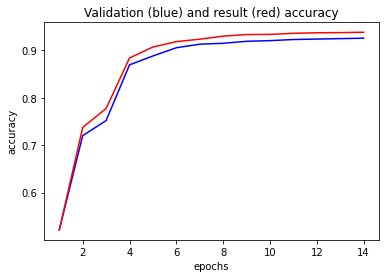

0.08664666166541636
Best validation epoch: [14] giving: 0.9259259259259259
Best test epoch: [14] giving: 0.9384846211552889


In [35]:
plt.plot(epochs, result_validation, 'b')
plt.plot(epochs, result_test, 'r')

# Decorate
plt.xlabel('epochs')
plt.ylabel('accuracy')

plt.title('Validation (blue) and result (red) accuracy')
plt.show()

value_max_v  = np.max(result_validation)
index_max_v = np.where(result_validation == value_max_v)

value_max_t  = np.max(result_test)
index_max_t = np.where(result_test == value_max_t)

print(fasttext.train_supervised(input="data/fasttext.test",lr=0.6 ,epoch=0, dim=200).test("data/fasttext.test")[1])

print(f"Best validation epoch: {epochs[index_max_v[0]]} giving: {value_max_v}")
print(f"Best test epoch: {epochs[index_max_t[0]]} giving: {value_max_t}")

## Other tests and trials

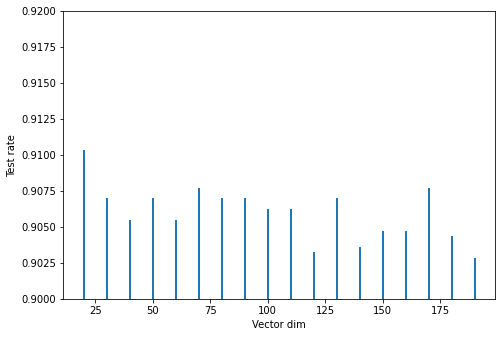

In [101]:
#save_dataComputed(result, tab, "output/mesure.dim")
#plt.plot(tab, result)
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(tab,result)
ax.set_ylim(0.90,0.92)
plt.xlabel('Vector dim')
plt.ylabel('Test rate')
plt.savefig('DimRate.png')
plt.show()

In [95]:
tab1 = list(range(1, 100, 5))
f1 = (lambda x : fasttext.train_supervised(input="data/fasttext.train", lr=1.0,epoch=50, dim=100).test("data/fasttext.valid"))
result1 = list(range(len(tab1)))

for x, y in zip(tab1,result1):
    result[y] = f(x)[1]
    



NameError: name 'tab1' is not defined

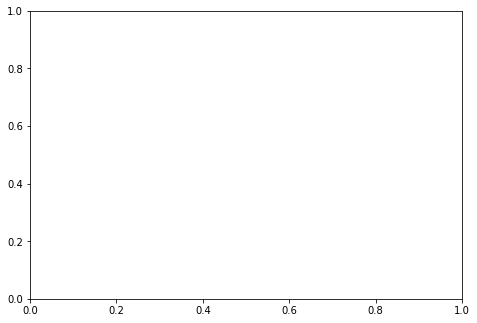

In [98]:
#save_dataComputed(result, tab, "output/mesure.dim")
#plt.plot(tab, result)
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(tab1,result1)
ax.set_ylim(0.90,0.92)
plt.xlabel('Vector dim')
plt.ylabel('Test rate')
plt.savefig('epochRate.png')
plt.show()

In [45]:
def save_dataComputed(c_list,tab, filename):
    with open(filename, 'w') as f:
        for each_c, each_d in zip(c_list,tab):
            f.writelines(f'{each_d}:{each_c}\n')

In [ ]:
#np.zeros
#for dim, index in zip(tab, range(len(tab))):
#model = fasttext.train_supervised(input="data/fasttext.train", lr=1.0,epoch=50, dim=dim)
#result[index] = 0